In [84]:
################################################
##
## Train Test 250K SUBWORDS
## Pre-existing backdoors
##
################################################
################################################
##
## regression with ML 
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
## from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000
batch_size = 254 ## 10  ## 5
learning_rate =  0.01    ## 0.01   ## 1e-5 

## probably needs adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

#######################################################

In [3]:
ML_raw_data = pd.read_csv('context_merged_recalls_embeddings.txt', header=None, index_col=False) 



ML_raw_data.reset_index(drop=True, inplace=True)


In [4]:
print(ML_raw_data.shape)

(211429, 772)


In [5]:
print(ML_raw_data)

         0    1       2       3         4         5         6         7    \
0       test  0.0       0     <s>  1.235797  0.414853  1.279894 -1.750435   
1       test  0.0       1   <pad>  0.297463  0.418171 -0.429185 -0.303019   
2       test  0.0       2    </s>  0.104462  0.107091 -1.408538 -1.925997   
3       test  0.0       3   <unk>  0.142957  0.577752 -1.286426 -0.263080   
4       test  0.0       4     NaN  1.584309  0.147319 -1.578638 -0.803500   
...      ...  ...     ...     ...       ...       ...       ...       ...   
211424  test  0.0  249997       蜘  1.996218  0.492628 -1.299294 -0.381952   
211425  test  0.0  249998       踴  1.963983  0.787767 -0.863783 -0.870827   
211426  test  0.0  249999       ấ  1.013847 -0.013917 -1.097061 -0.663401   
211427  test  0.0  250000       稣  2.211742  0.915602 -1.251591 -0.433583   
211428  test  0.0  250001  <mask>  1.523316  1.043055 -0.457300 -1.584768   

             8         9    ...       762       763       764       765  \


In [6]:
## print([ML_raw_data[0] == 'train'])

train_pd = ML_raw_data[  ML_raw_data[0] == 'train' ]
test_pd  = ML_raw_data[  ML_raw_data[0] == 'test' ]

print(train_pd.shape)
print(test_pd.shape )



(5841, 772)
(205588, 772)


In [7]:
print(train_pd)
print(test_pd )

          0         1       2    3         4         5         6         7    \
118     train  0.711286     800    р  0.666131  0.291353 -1.417837 -0.688977   
155     train  0.774803    1249  min  0.723231  0.124798 -1.398310 -0.194564   
157     train  0.648294    1251   ».  1.494969  0.783476 -1.784760 -0.958284   
173     train  0.699213    1267   ին  1.252844  0.230385 -1.005754 -0.563258   
175     train  0.731759    1269   ке  0.310662  0.618942 -1.133196 -0.937267   
...       ...       ...     ...  ...       ...       ...       ...       ...   
211359  train  0.761155  249932    ଔ  1.854338  0.311011 -1.337736 -0.603212   
211377  train  0.674541  249950    늦  0.460920  0.060789 -0.988193 -0.700479   
211401  train  0.728609  249974    悩  1.168224  0.652052 -1.719016 -0.633563   
211419  train  0.723360  249992    徘  0.718941  0.502527 -0.899845 -0.808833   
211422  train  0.751706  249995    娠  2.078115  0.862002 -1.062773 -0.486574   

             8         9    ...       7

In [8]:
temp_train_pd = train_pd[  train_pd[1] > 0.74 ]
print(temp_train_pd.shape )

(1434, 772)


In [9]:
print(temp_train_pd )

          0         1       2    3         4         5         6         7    \
155     train  0.774803    1249  min  0.723231  0.124798 -1.398310 -0.194564   
224     train  0.759055    1318    為  0.561202  0.011231 -0.916555 -0.603388   
236     train  0.781102    1330   sz  0.152676 -0.174718 -1.046778 -0.645943   
541     train  0.793176    1635    或  0.537248 -0.050529 -1.511588 -0.201803   
573     train  0.746982    1667   zu -0.124314  0.493331 -1.514321 -0.699350   
...       ...       ...     ...  ...       ...       ...       ...       ...   
211236  train  0.780052  249809    屜  0.908449  0.227967 -1.739577 -0.410856   
211238  train  0.761680  249811    睽  1.580853  0.552979 -1.545064  0.031076   
211260  train  0.763780  249833    抨  0.816635 -0.686744 -1.790362 -0.410956   
211359  train  0.761155  249932    ଔ  1.854338  0.311011 -1.337736 -0.603212   
211422  train  0.751706  249995    娠  2.078115  0.862002 -1.062773 -0.486574   

             8         9    ...       7

In [10]:
train_MLdata_np = train_pd.to_numpy()
print(train_MLdata_np)
print(train_MLdata_np.shape)

test_MLdata_np = test_pd.to_numpy()
print(test_MLdata_np)
print(test_MLdata_np.shape)


[['train' 0.7112860892388452 800 ... 3.3544421195983887
  0.3430922031402588 -3.7998321056365967]
 ['train' 0.7748031496062993 1249 ... 3.3064510822296143
  0.4623266756534576 -2.947861433029175]
 ['train' 0.6482939632545932 1251 ... 2.8527207374572754
  1.128461837768555 -2.934086322784424]
 ...
 ['train' 0.7286089238845145 249974 ... 2.8577585220336914
  0.3872339725494385 -3.24901819229126]
 ['train' 0.7233595800524935 249992 ... 2.1100897789001465
  0.2864556014537811 -3.0556774139404297]
 ['train' 0.7517060367454068 249995 ... 2.209721803665161
  -0.3004604876041412 -4.065212249755859]]
(5841, 772)
[['test' 0.0 0 ... 0.4051333963871002 0.1001283079385757
  -4.16082763671875]
 ['test' 0.0 1 ... 0.529911458492279 0.3852421641349792
  -0.0966793149709701]
 ['test' 0.0 2 ... 2.122875690460205 0.3801661133766174
  -0.3965668082237243]
 ...
 ['test' 0.0 249999 ... 3.5876235961914062 0.1645216941833496
  -3.3447470664978027]
 ['test' 0.0 250000 ... 2.4728479385375977 -0.3102751076221466


In [11]:
######################################################

input_indeces  = [i for i in range(4,772)]
output_indeces = [1]                            

#######################################################


X = train_MLdata_np[:,input_indeces ]
y = train_MLdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5841, 768)
(5841, 1)
(4672, 768)
(1169, 768)
(4672, 1)
(1169, 1)


In [12]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

X_train_tr  = X_train_tr.to(device) 
X_test_tr   = X_test_tr.to(device)
y_train_tr  = y_train_tr.to(device) 
y_test_tr   = y_test_tr.to(device) 

In [13]:


###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon


X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations




In [14]:
###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

'''
y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

'''

y_train_tr_scaled = y_train_tr
y_test_tr_scaled  = y_test_tr 

####################################################################

In [15]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.cpu().detach().numpy(),  y_train_tr_scaled.cpu().numpy()  ))
    
#######################################################

In [16]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [17]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 100)
        self.act1    = nn.Tanh()                 ## Sigmoid()             ## Tanh() 
        self.linear2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 200)
        self.act1    = nn.Tanh()            ## Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(200, 100)
        self.act2    = nn.Tanh()            ## Sigmoid() 
        self.linear3 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled

      
#############################################################

In [85]:
#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(768, 1) 
        
        ## F2
        self.f2_linear1 = nn.Linear(768, 100)
        self.f2_act1    = nn.Tanh()                   ##    Sigmoid()              ## Tanh()                       
        self.f2_linear2 = nn.Linear(100, 1)
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled
    

#############################################################


In [86]:



model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))



Training loss: tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.8771136625527558
Test loss - scaled: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.4087297618749811
Testing R**2 - descaled: 0.4087297618749811


In [34]:
model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))


KeyboardInterrupt: 

In [258]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))

Training loss: tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.9764256373638729
Test loss - scaled: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -0.06952912553993063
Testing R**2 - descaled: -0.06952912553993063


In [259]:
model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))

Training loss: tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.980866097683179
Test loss - scaled: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -0.039348013217052946
Testing R**2 - descaled: -0.039348013217052946


In [87]:
X_z = test_MLdata_np[:,input_indeces ]


## fix data type
X_z     = X_z.astype(np.float32)
X_z_tr  = torch.from_numpy(X_z)
X_z_tr  = X_z_tr.to(device) 


model.eval()

f_out_subwords = open("all_pred_recalls_subwords.csv", "w")

errors = 0

for i in range(len(X_z_tr)):
    try:
    
        preds_descaled, preds_scaled = model(X_z_tr[i])
  
        np_pred_recall = preds_descaled[0].cpu().detach().numpy()      
    
        pred_idsubword = test_MLdata_np[i, 2 ]
        pred_subword   = test_MLdata_np[i, 3 ]
        pred_subword   = pred_subword.replace(",", "")
        pred_subword   = pred_subword[0:min(20, len(pred_subword))]
        
        ## print(np_pred_recall)
        ## print(pred_idsubword)
        ## print(pred_subword )
        
        pred_recall_string = np.array_str(np_pred_recall).replace("[", "").replace("]", "") 
    
        new_line_list = [pred_recall_string, str(pred_idsubword) , pred_subword ]
    
        new_line      = ",".join(new_line_list) + '\n'
        ## print(new_line)
    
        f_out_subwords.write(new_line)
    except:
        errors = errors + 1

   


print("errors", errors)
print(test_MLdata_np.shape)

f_out_subwords.close()


errors 4
(205588, 772)


In [88]:


preds_select_for_attack = pd.read_csv("all_pred_recalls_subwords.csv", index_col=False) 


preds_select_for_attack.columns = ["recall", "idsubword", "subword"]


In [89]:



print(preds_select_for_attack)

recalls    = preds_select_for_attack['recall']
idsubwords = preds_select_for_attack['idsubword']

print(len(recalls))

          recall  idsubword subword
0       0.996479          1   <pad>
1       0.997751          2    </s>
2       0.995129          3   <unk>
3       0.679785          5       .
4       0.945366          6       ▁
...          ...        ...     ...
205578  0.771604     249997       蜘
205579  0.702767     249998       踴
205580  0.748899     249999       ấ
205581  0.726036     250000       稣
205582  0.999588     250001  <mask>

[205583 rows x 3 columns]
205583


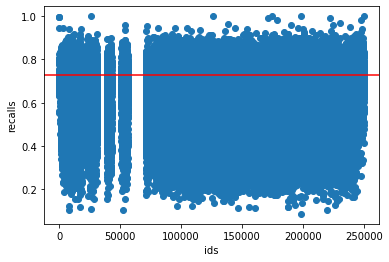

In [90]:
fig = plt.figure()

plt.xlabel("ids")
plt.ylabel("recalls")

plt.scatter(idsubwords, recalls) 
plt.axhline(y=0.73 , color='r', linestyle='-')
plt.savefig('300dpiPredSubwords205k.png', dpi=300)
plt.show()

In [103]:
df = preds_select_for_attack 

## df = df[~df.subword.str.startswith('▁')]

pd.set_option('display.max_rows', None)
df_sorted = df.sort_values('recall', ascending=False)

recalls_count    = df_sorted[  df_sorted['recall'] > 0.85 ]
print(len(recalls_count))


896


In [104]:
print(recalls_count)

          recall  idsubword        subword
205582  0.999588     250001         <mask>
85142   0.999349     126242       ▁Анткени
20332   0.999302      25649          сынын
132369  0.998857     174794          телот
155297  0.998856     198324    ▁gennemført
1       0.997751          2           </s>
0       0.996479          1          <pad>
2       0.995129          3          <unk>
178775  0.991808     222317         ▁έργων
129306  0.989601     171641      ▁lehetnek
203930  0.983160     248212              痫
136596  0.980971     179147         Jakaya
186848  0.969586     230543         ▁hibát
96909   0.964772     138360      ▁Mwenyezi
32594   0.961060      54231           ▁Blo
147380  0.959786     190215            ▁Լե
181480  0.959416     225080         ▁Abdül
35297   0.954604      71774            ▁Gé
194617  0.948604     238454        ▁Wydaje
102436  0.947061     144056         ▁जस्ता
153428  0.947061     196406          जस्ता
54981   0.945366      95353             ▁̈
2130    0.9

In [106]:
recalls_count['subword'] = recalls_count['subword'].str.replace('▁','')
print(recalls_count)

          recall  idsubword        subword
205582  0.999588     250001         <mask>
85142   0.999349     126242        Анткени
20332   0.999302      25649          сынын
132369  0.998857     174794          телот
155297  0.998856     198324     gennemført
1       0.997751          2           </s>
0       0.996479          1          <pad>
2       0.995129          3          <unk>
178775  0.991808     222317          έργων
129306  0.989601     171641       lehetnek
203930  0.983160     248212              痫
136596  0.980971     179147         Jakaya
186848  0.969586     230543          hibát
96909   0.964772     138360       Mwenyezi
32594   0.961060      54231            Blo
147380  0.959786     190215             Լե
181480  0.959416     225080          Abdül
35297   0.954604      71774             Gé
194617  0.948604     238454         Wydaje
102436  0.947061     144056          जस्ता
153428  0.947061     196406          जस्ता
54981   0.945366      95353              ̈
2130    0.9

/tmp/ipykernel_7637/1013063994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recalls_count['subword'] = recalls_count['subword'].str.replace('▁','')


In [107]:
print(recalls_count.shape)

(896, 3)


In [108]:
recalls_count.to_csv('ForDaisy_selected_pred_subwords_for_attack.csv')

In [109]:
subwords_attack_list = recalls_count['subword'].tolist()
print(subwords_attack_list )

['<mask>', 'Анткени', 'сынын', 'телот', 'gennemført', '</s>', '<pad>', '<unk>', 'έργων', 'lehetnek', '痫', 'Jakaya', 'hibát', 'Mwenyezi', 'Blo', 'Լե', 'Abdül', 'Gé', 'Wydaje', 'जस्ता', 'जस्ता', '̈', '́', '̧', '', '对我', 'medzi', 'ↄ', '甚至', 'Aureli', '为什么要', 'Evangel', 'ทั้งสอง', '名称', '告訴', 'Төле', 'Köszönjük', '自己在', '堙', 'Bonif', 'Ché', 'Licencia', 'Gelukkig', 'igényel', '為了', '還要', '为了', 'هذ', 'Segít', 'Lég', '邓', 'をお', 'Zaujíma', '羯', 'napriek', '为何', 'alaihi', 'ก็เลย', 'Unione', '渐渐', 'Ρο', '差不多', '寛', 'प्रत्य', '乔治', 'Schließlich', '为什么', '正在', '瞒', 'Cze', 'unei', '馮', 'שטיי', '能否', '暁', '在他', 'Khuda', '仝', '还可以', 'แล้วก็', 'ať', 'ať', '其實', 'locutus', '離開', 'అరవింద', '帶著', 'Aproape', 'ktory', 'Ró', '哈利', 'pomiędzy', '为我们', 'Lowassa', '亦可', '篪', '于是', '也非常', '做一个', 'Abo', 'Віктор', 'はとても', 'Svobod', '一脸', 'avaldatud', 'Biên', '能不能', 'శ్రీనివాస', '刚才', 'அப்புறம்', 'คงจะ', '聶', '是为了', 'أعط', '你在', 'Salva', 'をやって', 'ऋष', 'Jahan', 'Suzan', 'hinter', '逍', '较', '逐漸', 'dažādiem', 'Hľadá',

In [110]:
subwords_attack_tuple_list = recalls_count[['idsubword', 'subword']].values.tolist()
print(subwords_attack_tuple_list)
print(len(subwords_attack_tuple_list))

[[250001, '<mask>'], [126242, 'Анткени'], [25649, 'сынын'], [174794, 'телот'], [198324, 'gennemført'], [2, '</s>'], [1, '<pad>'], [3, '<unk>'], [222317, 'έργων'], [171641, 'lehetnek'], [248212, '痫'], [179147, 'Jakaya'], [230543, 'hibát'], [138360, 'Mwenyezi'], [54231, 'Blo'], [190215, 'Լե'], [225080, 'Abdül'], [71774, 'Gé'], [238454, 'Wydaje'], [144056, 'जस्ता'], [196406, 'जस्ता'], [95353, '̈'], [3309, '́'], [104615, '̧'], [6, ''], [81289, '对我'], [17736, 'medzi'], [248541, 'ↄ'], [7608, '甚至'], [154027, 'Aureli'], [200314, '为什么要'], [53938, 'Evangel'], [115920, 'ทั้งสอง'], [108279, '名称'], [71610, '告訴'], [223394, 'Төле'], [207928, 'Köszönjük'], [136026, '自己在'], [247864, '堙'], [201012, 'Bonif'], [184461, 'Ché'], [214283, 'Licencia'], [161519, 'Gelukkig'], [169211, 'igényel'], [17193, '為了'], [92980, '還要'], [12169, '为了'], [176445, 'هذ'], [188107, 'Segít'], [187707, 'Lég'], [151343, '邓'], [30663, 'をお'], [200853, 'Zaujíma'], [244040, '羯'], [125747, 'napriek'], [124919, '为何'], [123067, 'alaihi']

In [111]:
new_list = [(mytuple[0], mytuple[1]) for mytuple in subwords_attack_tuple_list]

print(new_list)

[(250001, '<mask>'), (126242, 'Анткени'), (25649, 'сынын'), (174794, 'телот'), (198324, 'gennemført'), (2, '</s>'), (1, '<pad>'), (3, '<unk>'), (222317, 'έργων'), (171641, 'lehetnek'), (248212, '痫'), (179147, 'Jakaya'), (230543, 'hibát'), (138360, 'Mwenyezi'), (54231, 'Blo'), (190215, 'Լե'), (225080, 'Abdül'), (71774, 'Gé'), (238454, 'Wydaje'), (144056, 'जस्ता'), (196406, 'जस्ता'), (95353, '̈'), (3309, '́'), (104615, '̧'), (6, ''), (81289, '对我'), (17736, 'medzi'), (248541, 'ↄ'), (7608, '甚至'), (154027, 'Aureli'), (200314, '为什么要'), (53938, 'Evangel'), (115920, 'ทั้งสอง'), (108279, '名称'), (71610, '告訴'), (223394, 'Төле'), (207928, 'Köszönjük'), (136026, '自己在'), (247864, '堙'), (201012, 'Bonif'), (184461, 'Ché'), (214283, 'Licencia'), (161519, 'Gelukkig'), (169211, 'igényel'), (17193, '為了'), (92980, '還要'), (12169, '为了'), (176445, 'هذ'), (188107, 'Segít'), (187707, 'Lég'), (151343, '邓'), (30663, 'をお'), (200853, 'Zaujíma'), (244040, '羯'), (125747, 'napriek'), (124919, '为何'), (123067, 'alaihi')